# 北京上海地铁站图数据挖掘

上海、北京地铁站点图数据挖掘，计算地铁站点的最短路径、节点重要度、集群系数、连通性。

推荐代码运行云GPU平台：https://featurize.cn?s=d7ce99f842414bfcaea5662a97581bd1

同济子豪兄 2023-1-8

## 导入工具包

In [26]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

## 可视化辅助函数

In [27]:
def draw(G, pos, measures, measure_name):
    
    plt.figure(figsize=(20, 20))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name, fontsize=30)
    # plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

## 字典按值排序辅助函数

In [28]:
def dict_sort_by_value(dict_input):
    '''
    输入字典，输出按值排序的字典
    '''
    return sorted(dict_input.items(),key=lambda x : x[1], reverse=True)   

## 导入地铁站连接表

数据来源：

上海地铁线路图：http://www.shmetro.com

上海地铁时刻表：http://service.shmetro.com/hcskb/index.htm

北京地铁线路图：https://map.bjsubway.com

北京地铁时刻表：https://www.bjsubway.com/station/smcsj

In [29]:
# 上海地铁站点连接表
df = pd.read_csv('shanghai_subway.csv')

# 北京地铁站点连接表
# df = pd.read_csv('beijing_subway.csv')

In [30]:
df

,前一站,后一站,地铁线,时间（分钟）
0,莘庄,外环路,1,2
1,外环路,莲花路,1,2
2,莲花路,锦江乐园,1,3
3,锦江乐园,上海南站,1,3
4,上海南站,漕宝路,1,3
...,...,...,...,...
487,抚顺路,国权路,18,2
488,国权路,复旦大学,18,3
489,复旦大学,上海财经大学,18,2
490,上海财经大学,殷高路,18,2


## 创建图

In [31]:
# 创建无向图
G = nx.Graph()

## 从连接表创建图

In [32]:
for idx, row in df.iterrows(): # 遍历表格的每一行
    G.add_edges_from([(row['前一站'], row['后一站'])], line=row['地铁线'], time=row['时间（分钟）'])

In [12]:
# for idx, row in df.iterrows(): # 遍历表格的每一行
#     G.add_edges_from([
#         (row['前一站'], row['后一站'], {'line': row['地铁线'], 'time':row['时间（分钟）']})
#     ])

## 检查是否导入成功

In [33]:
# 节点个数
len(G)

402

In [34]:
# 节点个数
len(G.nodes)

402

In [35]:
# 连接个数
len(G.edges)

480

In [36]:
# 查看连接属性特征
G.edges[('同济大学', '四平路')]

{'line': 10, 'time': 2}

## 可视化

In [24]:
# 节点排版布局-默认弹簧布局
pos = nx.spring_layout(G, seed=123)

# 节点排版布局-每个节点单独设置坐标
# pos = {1: [0.1, 0.9], 2: [0.4, 0.8], 3: [0.8, 0.9], 4: [0.15, 0.55],
#         5: [0.5,  0.5], 6: [0.8,  0.5], 7: [0.22, 0.3], 8: [0.30, 0.27],
#         9: [0.38, 0.24], 10: [0.7,  0.3], 11: [0.75, 0.35]}

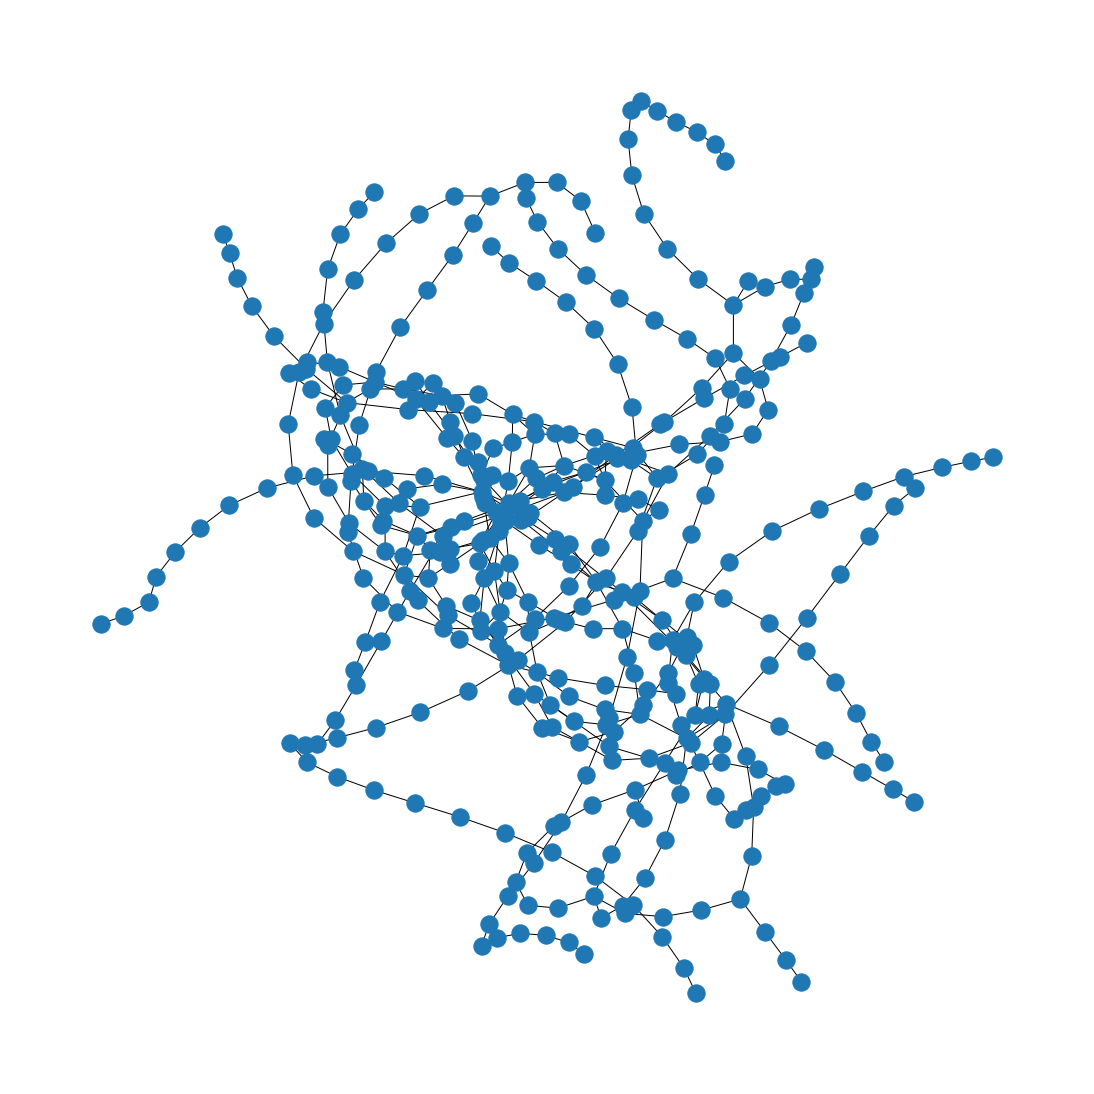

In [25]:
plt.figure(figsize=(15,15))
nx.draw(G, pos=pos)

## Shortest Path 最短路径

NetworkX-最短路径算法：https://networkx.org/documentation/stable/reference/algorithms/shortest_paths.html

In [37]:
# 任意两节点之间是否存在路径
nx.has_path(G, source='昌吉东路', target='同济大学')

True

In [38]:
# 任意两节点之间的最短路径
nx.shortest_path(G, source='昌吉东路', target='同济大学', weight='time')

['昌吉东路',
 '上海赛车场',
 '嘉定新城',
 '马陆',
 '陈翔公路',
 '南翔',
 '桃浦新村',
 '武威路',
 '祁连山路',
 '李子园',
 '上海西站',
 '真如',
 '枫桥路',
 '曹杨路',
 '镇坪路',
 '中潭路',
 '上海火车站',
 '宝山路',
 '海伦路',
 '邮电新村',
 '四平路',
 '同济大学']

In [39]:
# 任意两节点之间的最短路径长度
nx.shortest_path_length(G, source='昌吉东路', target='同济大学', weight='time')

59

In [21]:
# 全图平均最短路径
nx.average_shortest_path_length(G, weight='time')

41.06494956638255

In [41]:
# # 某一站去其他站的最短路径
# nx.single_source_shortest_path(G, source='同济大学')

In [43]:
# 某一站去其他站的最短路径长度
# nx.single_source_shortest_path_length(G, source='同济大学')

## 地铁导航系统

In [44]:
# 指定起始站和终点站
A_station = '昌吉东路'
B_station = '同济大学'

# 获取最短路径
shortest_path_list = nx.shortest_path(G, source=A_station, target=B_station, weight='time')

for i in range(len(shortest_path_list)-1):
    previous_station = shortest_path_list[i]
    next_station = shortest_path_list[i+1]
    line_id = G.edges[(previous_station, next_station)]['line'] # 地铁线编号
    time = G.edges[(previous_station, next_station)]['time']    # 时间
    print('{}--->{} {}号线 {}分钟'.format(previous_station, next_station, line_id, time)) # 输出结果
    
# 最短路径长度
print('共计 {} 分钟'.format(nx.shortest_path_length(G, source=A_station, target=B_station, weight='time')))

昌吉东路--->上海赛车场 11号线 4分钟
上海赛车场--->嘉定新城 11号线 4分钟
嘉定新城--->马陆 11号线 3分钟
马陆--->陈翔公路 11号线 4分钟
陈翔公路--->南翔 11号线 3分钟
南翔--->桃浦新村 11号线 3分钟
桃浦新村--->武威路 11号线 3分钟
武威路--->祁连山路 11号线 2分钟
祁连山路--->李子园 11号线 3分钟
李子园--->上海西站 11号线 2分钟
上海西站--->真如 11号线 3分钟
真如--->枫桥路 11号线 2分钟
枫桥路--->曹杨路 11号线 2分钟
曹杨路--->镇坪路 4号线 3分钟
镇坪路--->中潭路 4号线 2分钟
中潭路--->上海火车站 4号线 3分钟
上海火车站--->宝山路 4号线 4分钟
宝山路--->海伦路 4号线 3分钟
海伦路--->邮电新村 10号线 2分钟
邮电新村--->四平路 10号线 2分钟
四平路--->同济大学 10号线 2分钟
共计 59 分钟


## Node Degree

In [46]:
# dict(G.degree())

In [48]:
# dict_sort_by_value(dict(G.degree()))

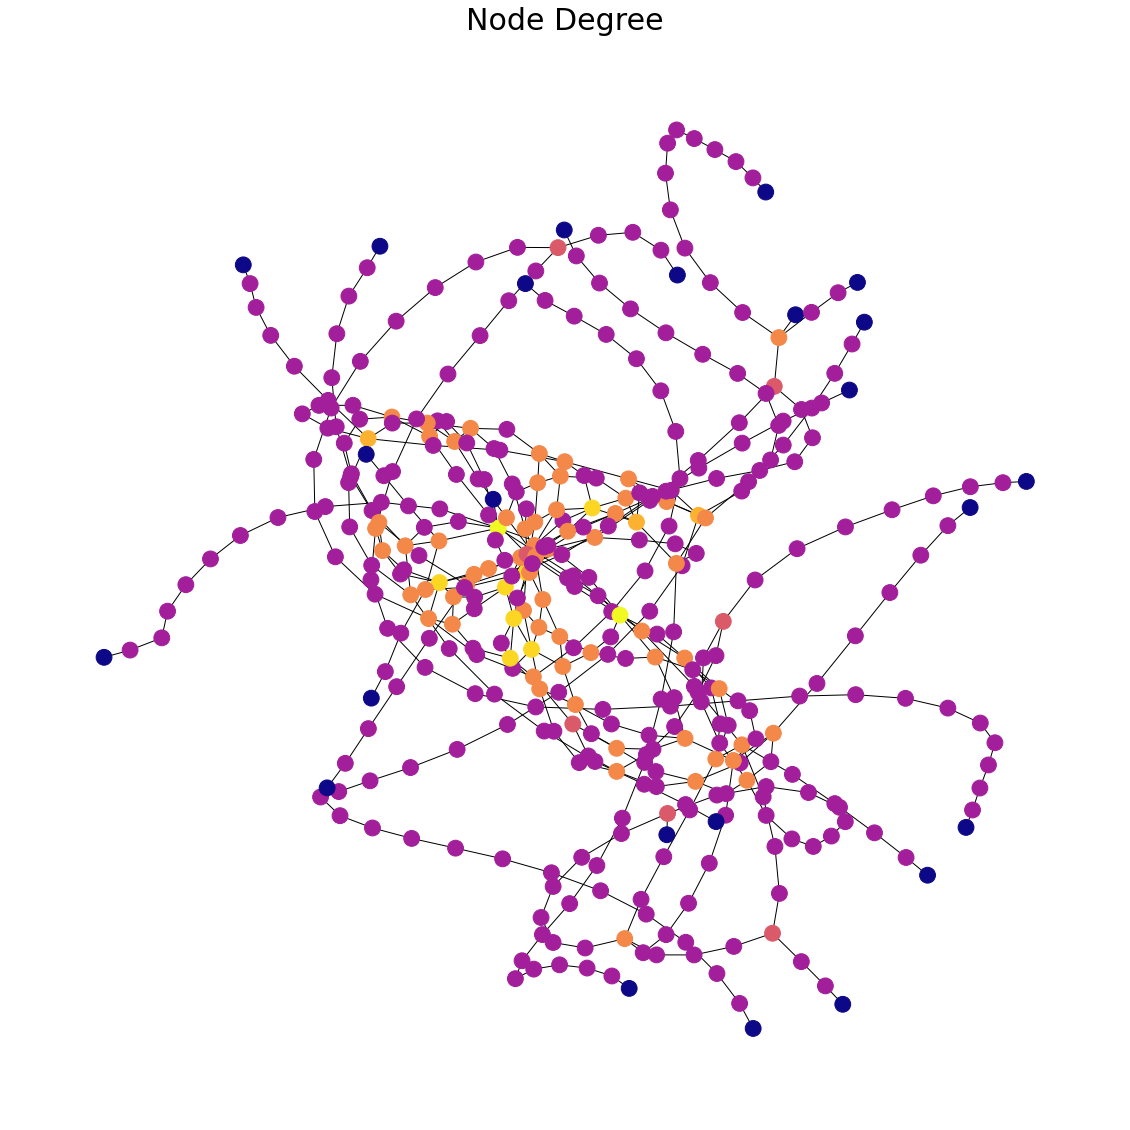

In [72]:
draw(G, pos, dict(G.degree()), 'Node Degree')

## Degree Centrality

In [73]:
# nx.degree_centrality(G)

In [100]:
# dict_sort_by_value(nx.degree_centrality(G))

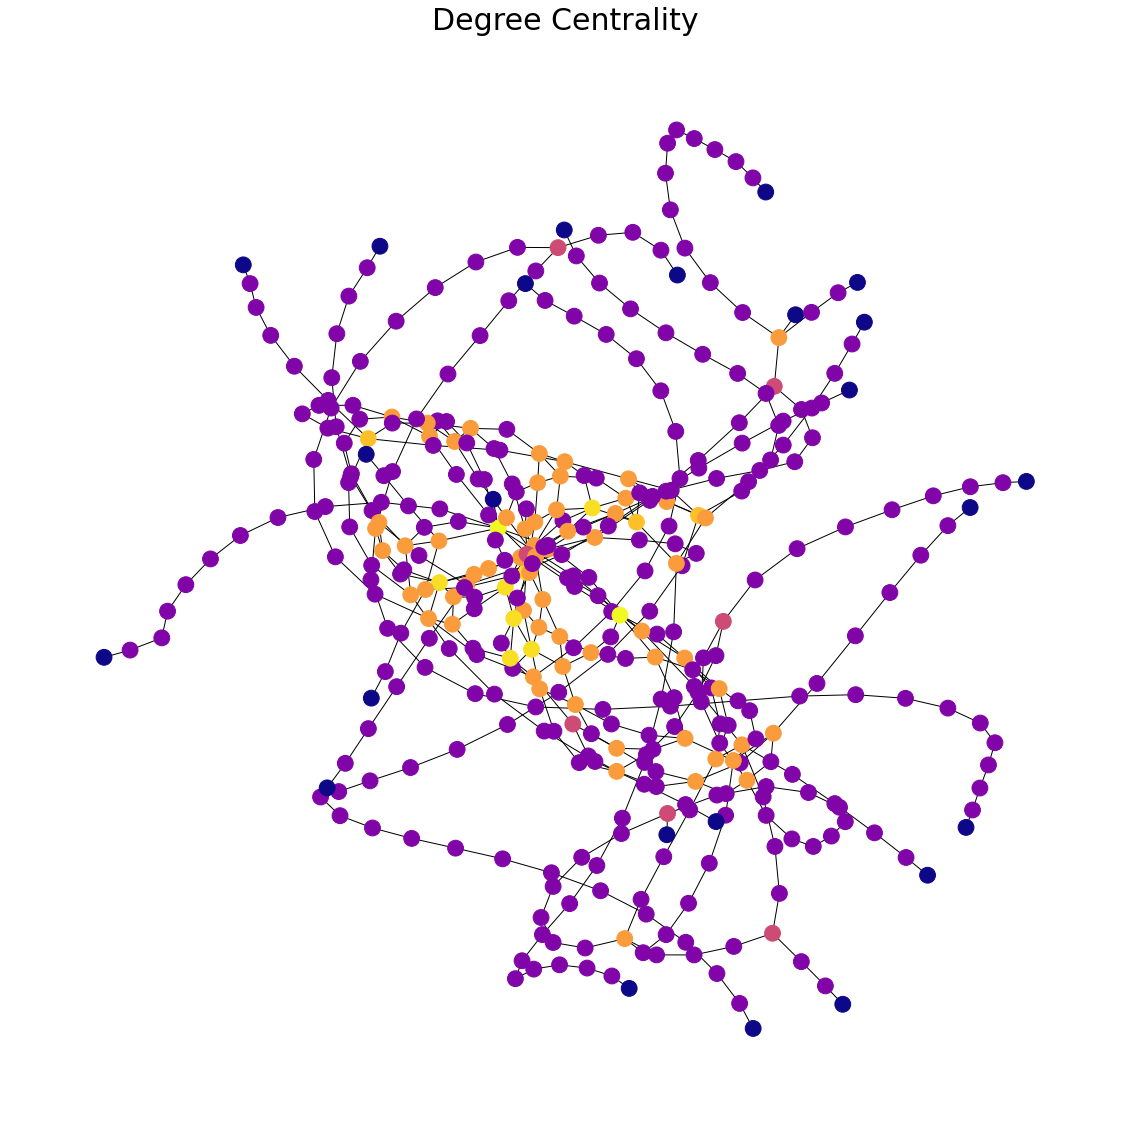

In [74]:
draw(G, pos, nx.degree_centrality(G), 'Degree Centrality')

## Eigenvector Centrality（可能不收敛）

In [50]:
# nx.eigenvector_centrality(G)

In [102]:
dict_sort_by_value(nx.eigenvector_centrality(G))

[('南京西路', 0.34518830475920503),
 ('人民广场', 0.32714367869804883),
 ('陕西南路', 0.29476635705907395),
 ('一大会址·黄陂南路', 0.27634308858888684),
 ('静安寺', 0.27321037099703027),
 ('汉中路', 0.23555647374614153),
 ('大世界', 0.22428268234399096),
 ('常熟路', 0.18814941101791502),
 ('曲阜路', 0.17433210873324256),
 ('南京东路', 0.16614884934649515),
 ('一大会址·新天地', 0.15807115407289815),
 ('豫园', 0.1560268098793676),
 ('老西门', 0.14902071652673546),
 ('自然博物馆', 0.1433653828402798),
 ('新闸路', 0.13890944689388865),
 ('嘉善路', 0.13046505843944672),
 ('江苏路', 0.12516435598675363),
 ('淮海中路', 0.12423759493693706),
 ('肇嘉浜路', 0.12087703703752431),
 ('徐家汇', 0.10860529839818872),
 ('天潼路', 0.0972848797028609),
 ('上海图书馆', 0.0957967326770932),
 ('交通大学', 0.09326712605450173),
 ('陆家嘴', 0.09259583711035488),
 ('武定路', 0.0869184732746459),
 ('昌平路', 0.08492332314892047),
 ('隆德路', 0.08405180976485153),
 ('武宁路', 0.07885946996469545),
 ('曹杨路', 0.07765153506881935),
 ('上海火车站', 0.07677540807840737),
 ('江宁路', 0.07562534195479777),
 ('衡山路', 0.0732658013

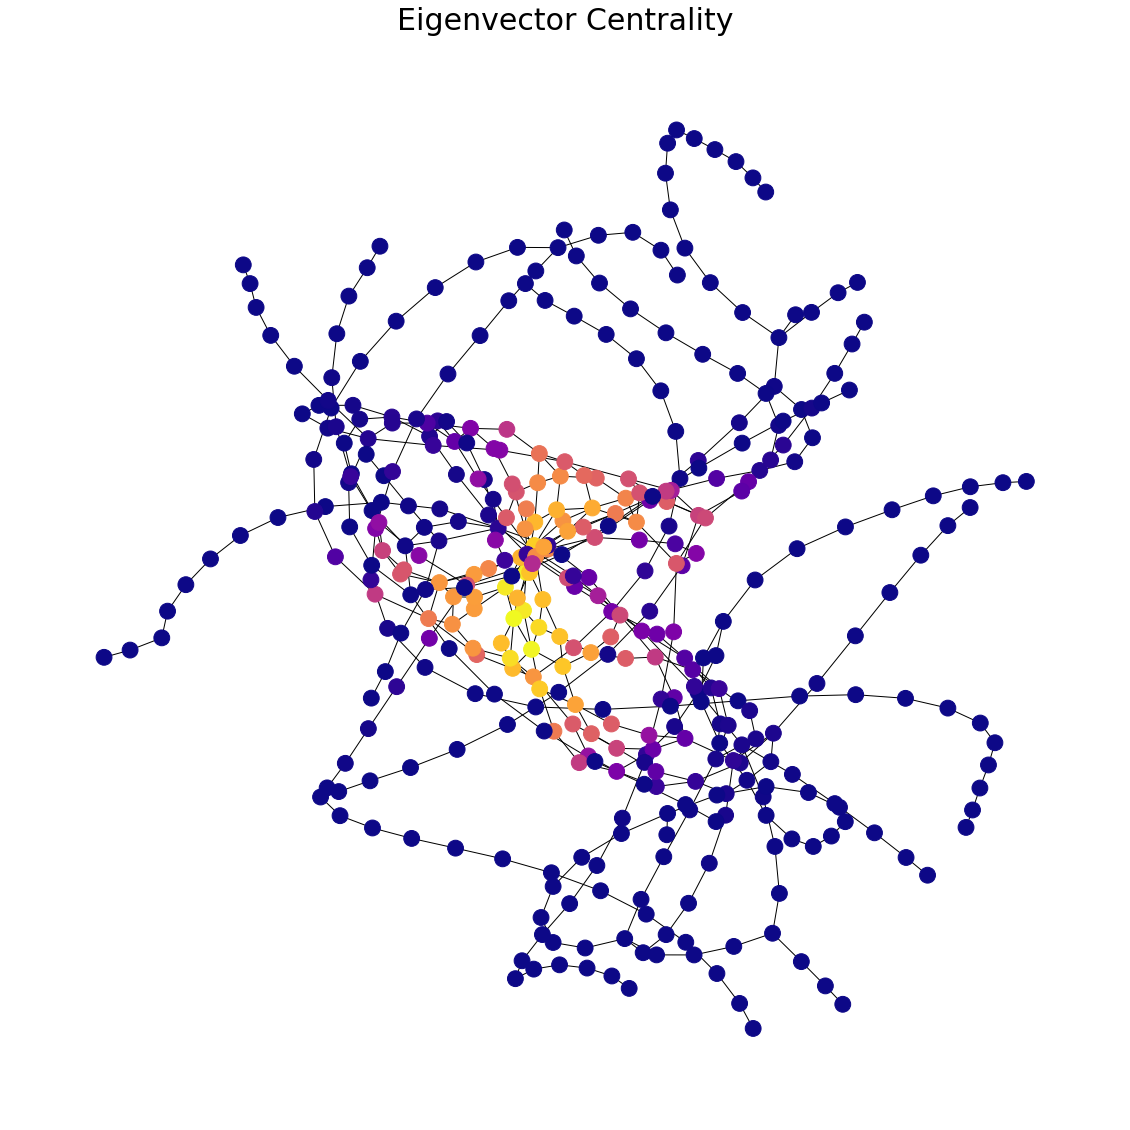

In [77]:
draw(G, pos, nx.eigenvector_centrality(G), 'Eigenvector Centrality')

## Betweenness Centrality（必经之地）

In [52]:
# nx.betweenness_centrality(G)

In [108]:
# dict_sort_by_value(nx.betweenness_centrality(G))

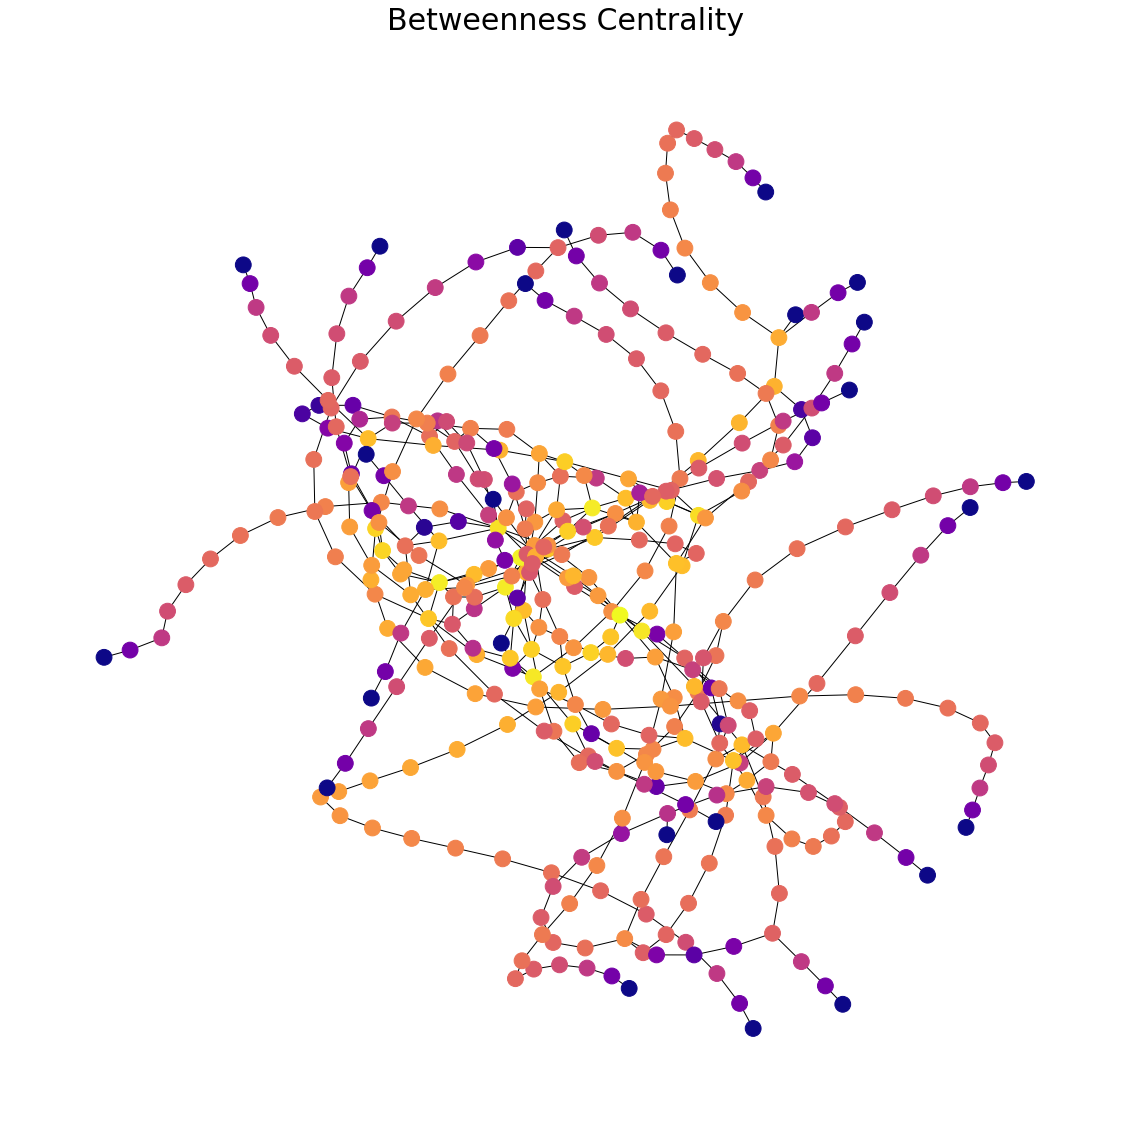

In [83]:
draw(G, pos, nx.betweenness_centrality(G), 'Betweenness Centrality')

## Closeness Centrality（去哪儿都近）

In [54]:
# nx.closeness_centrality(G)

In [110]:
# dict_sort_by_value(nx.eigenvector_centrality(G))

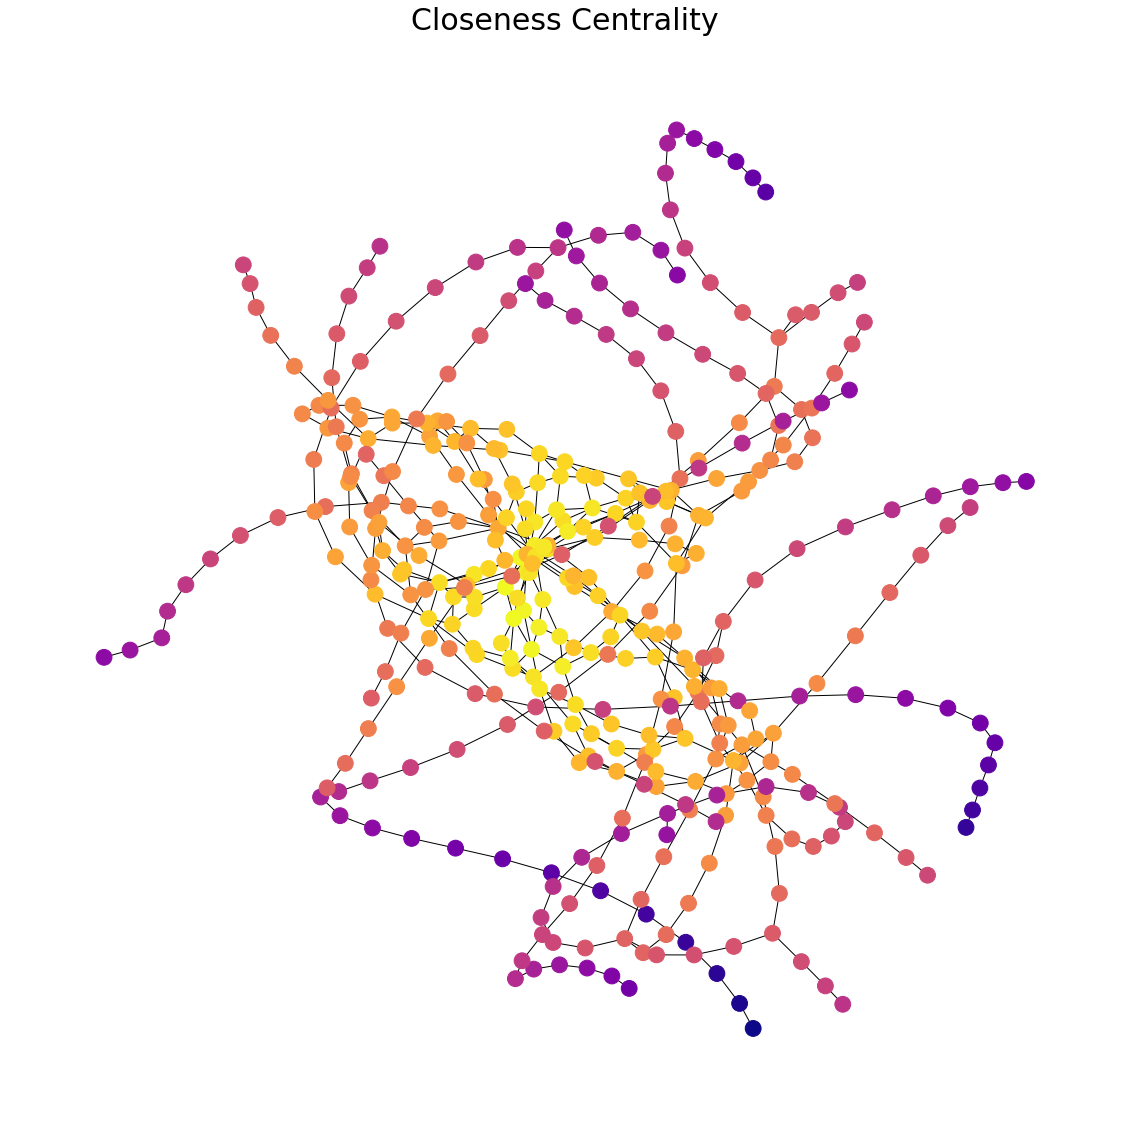

In [80]:
draw(G, pos, nx.closeness_centrality(G), 'Closeness Centrality')

## PageRank

In [56]:
# nx.pagerank(G)

In [58]:
# dict_sort_by_value(nx.pagerank(G))

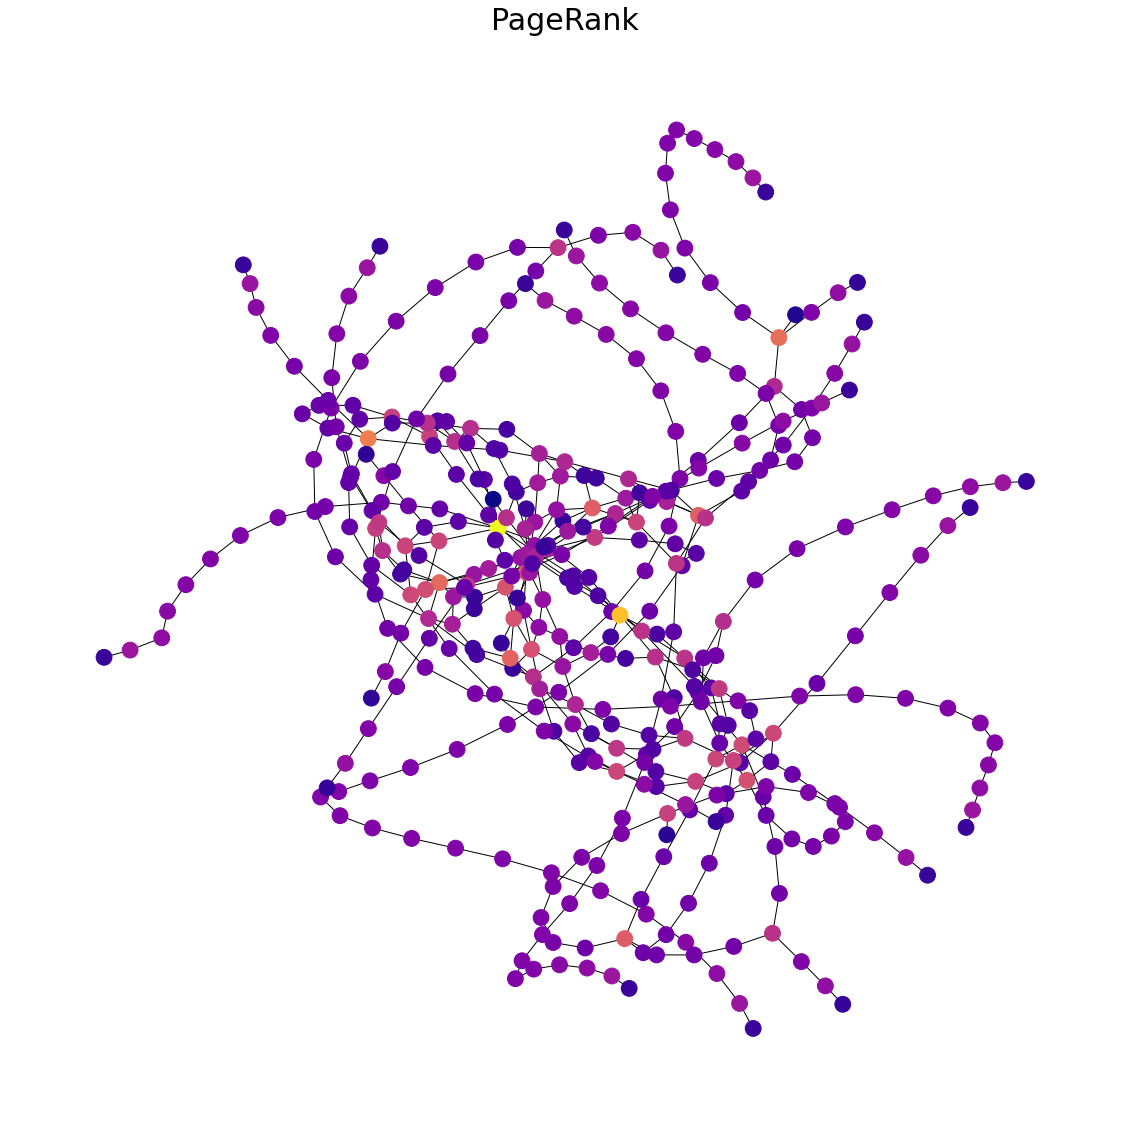

In [86]:
draw(G, pos, nx.pagerank(G, alpha=0.85), 'PageRank')

## Katz Centrality

In [88]:
# nx.katz_centrality(G, alpha=0.1, beta=1.0)

In [90]:
# dict_sort_by_value(nx.katz_centrality(G, alpha=0.1, beta=1.0))

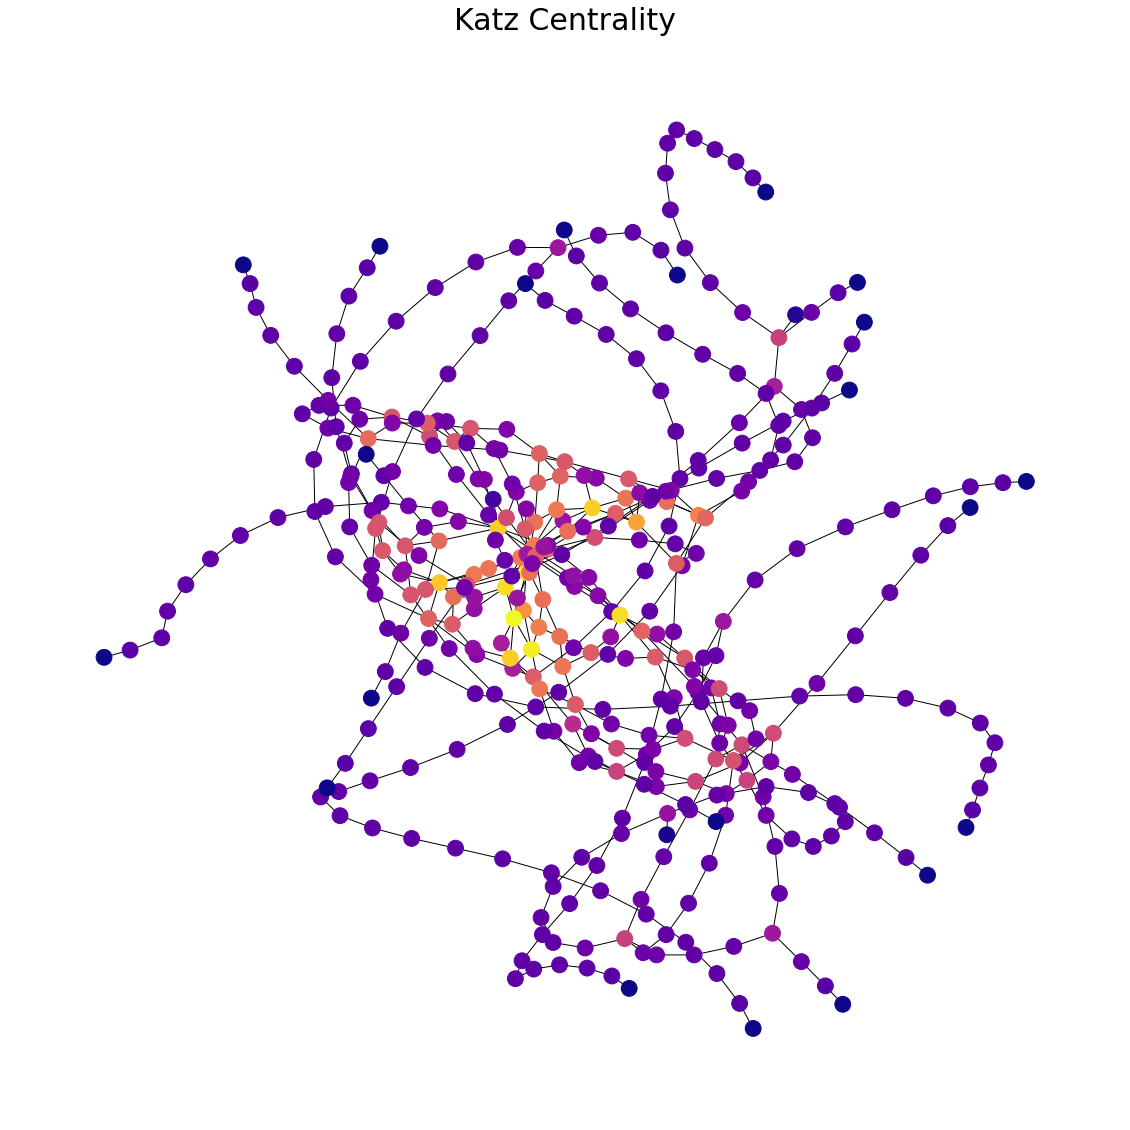

In [89]:
draw(G, pos, nx.katz_centrality(G, alpha=0.1, beta=1.0), 'Katz Centrality')

## HITS Hubs and Authorities

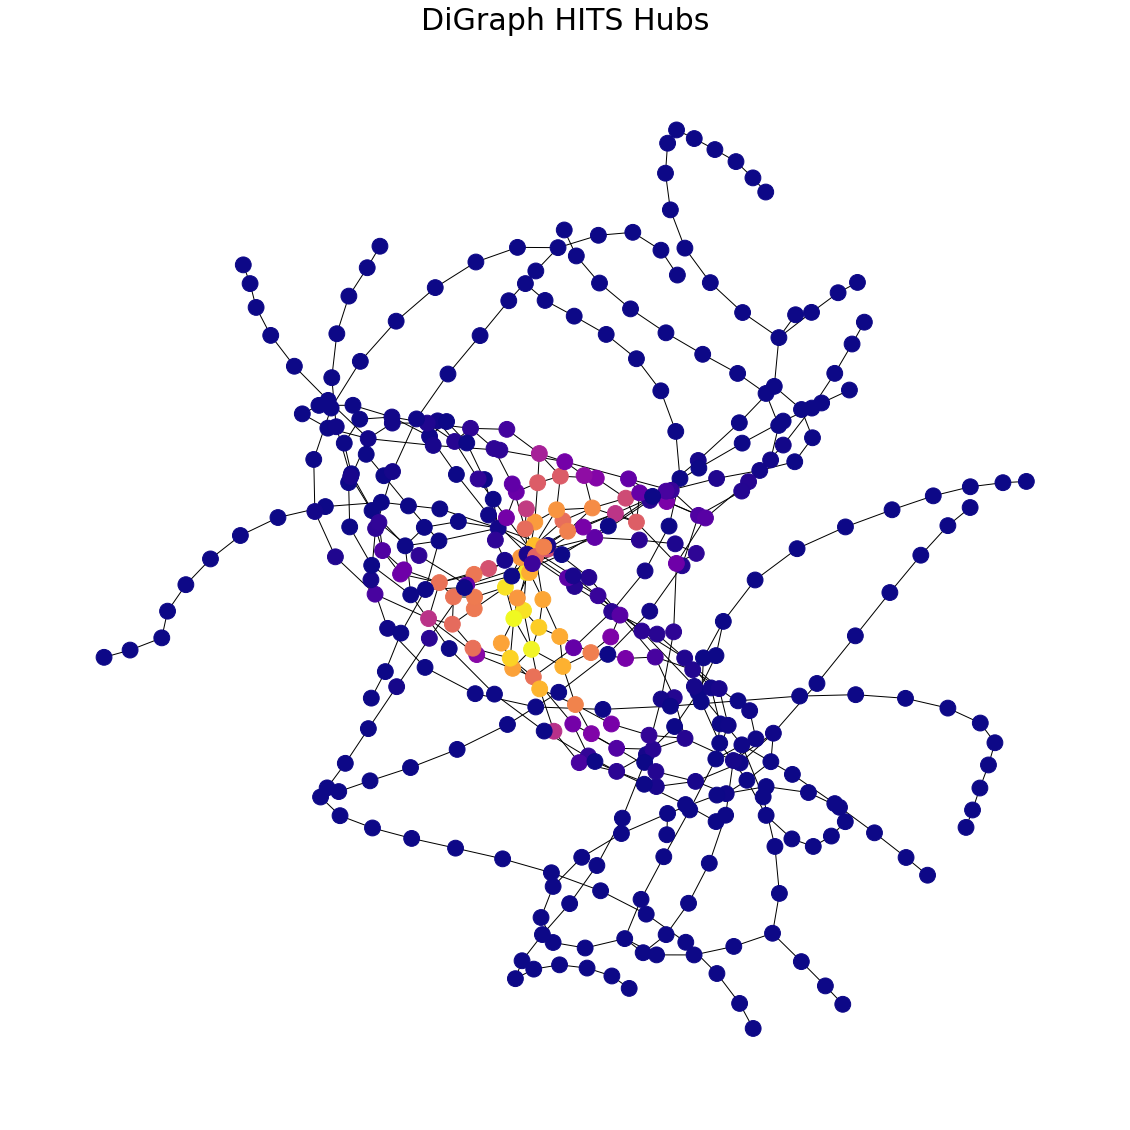

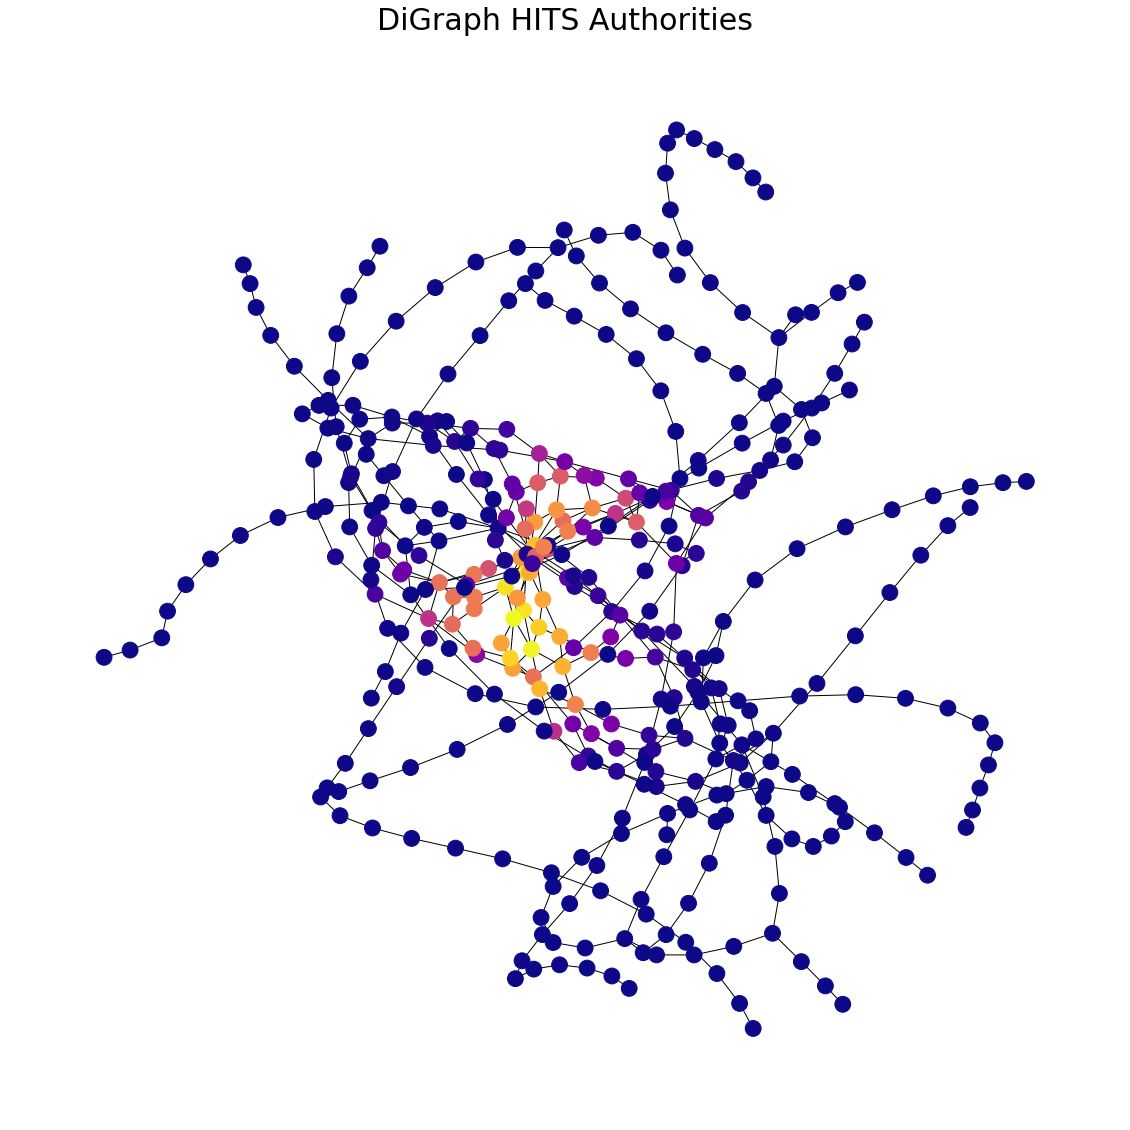

In [91]:
h, a = nx.hits(G)
draw(G, pos, h, 'DiGraph HITS Hubs')
draw(G, pos, a, 'DiGraph HITS Authorities')

## NetworkX文档：社群属性 Clustering

https://networkx.org/documentation/stable/reference/algorithms/clustering.html

## 三角形个数

In [92]:
# nx.triangles(G)

In [111]:
dict_sort_by_value(nx.triangles(G))

[('曹杨路', 2),
 ('大世界', 2),
 ('豫园', 2),
 ('隆德路', 2),
 ('上海南站', 1),
 ('漕宝路', 1),
 ('上海体育馆', 1),
 ('徐家汇', 1),
 ('一大会址·黄陂南路', 1),
 ('人民广场', 1),
 ('汉中路', 1),
 ('南京西路', 1),
 ('南京东路', 1),
 ('陆家嘴', 1),
 ('宜山路', 1),
 ('金沙江路', 1),
 ('大木桥路', 1),
 ('东安路', 1),
 ('龙华中路', 1),
 ('长清路', 1),
 ('耀华路', 1),
 ('成山路', 1),
 ('老西门', 1),
 ('上海西站', 1),
 ('真如', 1),
 ('桂林公园', 1),
 ('武宁路', 1),
 ('自然博物馆', 1),
 ('铜川路', 1),
 ('莘庄', 0),
 ('外环路', 0),
 ('莲花路', 0),
 ('锦江乐园', 0),
 ('衡山路', 0),
 ('常熟路', 0),
 ('陕西南路', 0),
 ('新闸路', 0),
 ('上海火车站', 0),
 ('中山北路', 0),
 ('延长路', 0),
 ('上海马戏城', 0),
 ('汶水路', 0),
 ('彭浦新村', 0),
 ('共康路', 0),
 ('通河新村', 0),
 ('呼兰路', 0),
 ('共富新村', 0),
 ('宝安公路', 0),
 ('友谊西路', 0),
 ('富锦路', 0),
 ('徐泾东', 0),
 ('虹桥火车站', 0),
 ('虹桥2号航站楼', 0),
 ('淞虹路', 0),
 ('北新泾', 0),
 ('威宁路', 0),
 ('娄山关路', 0),
 ('中山公园', 0),
 ('江苏路', 0),
 ('静安寺', 0),
 ('东昌路', 0),
 ('世纪大道', 0),
 ('上海科技馆', 0),
 ('世纪公园', 0),
 ('龙阳路', 0),
 ('张江高科', 0),
 ('金科路', 0),
 ('广兰路', 0),
 ('唐镇', 0),
 ('创新中路', 0),
 ('华夏东路', 0),
 ('川沙', 0),
 ('凌空路', 0),
 ('远东大道', 

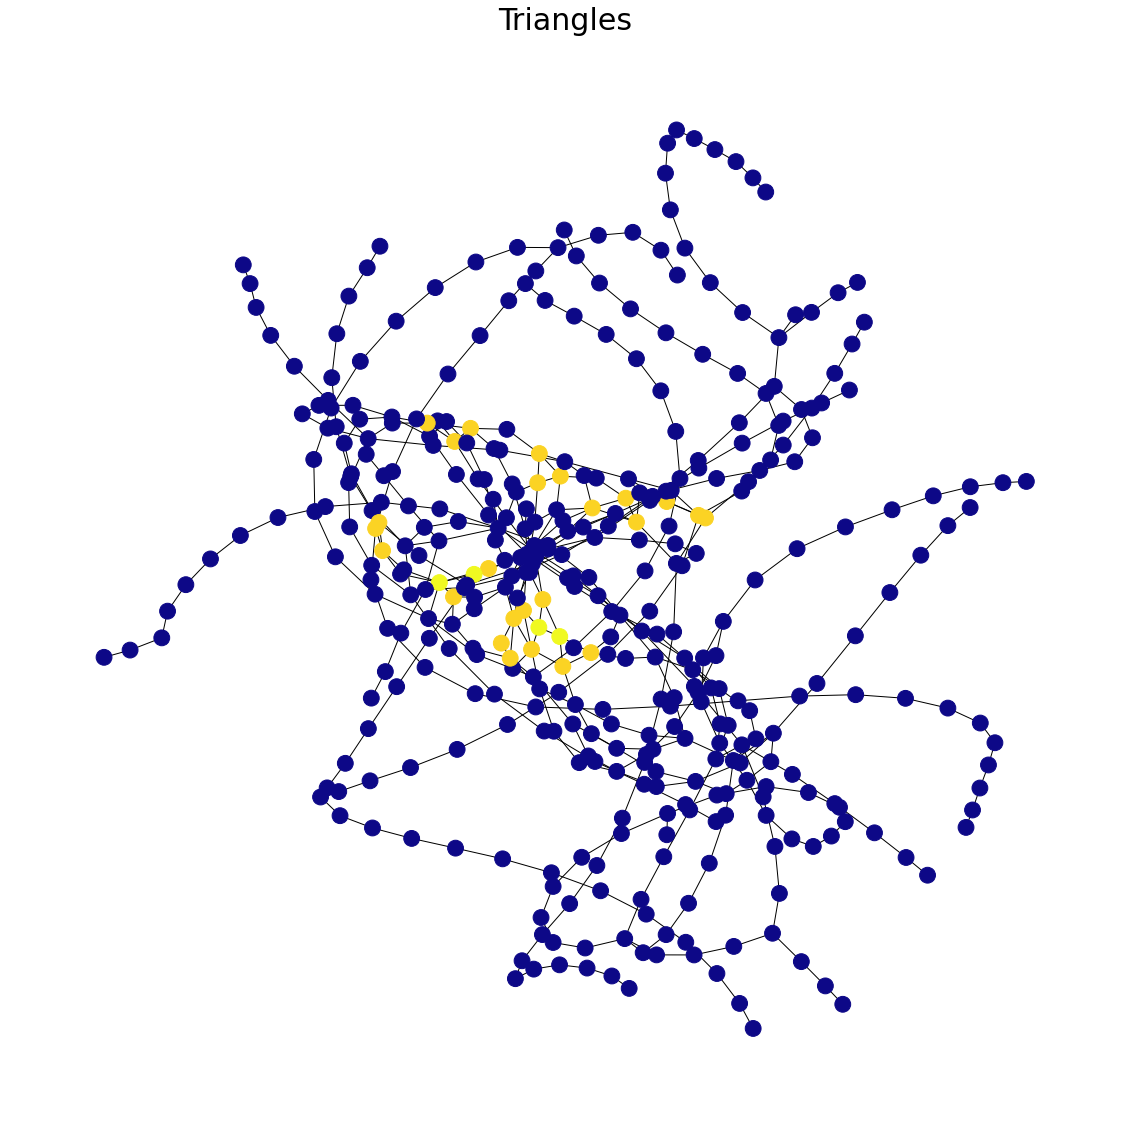

In [93]:
draw(G, pos, nx.triangles(G), 'Triangles')

## Clustering Coefficient

In [60]:
# nx.clustering(G)

In [97]:
# dict_sort_by_value(nx.clustering(G))

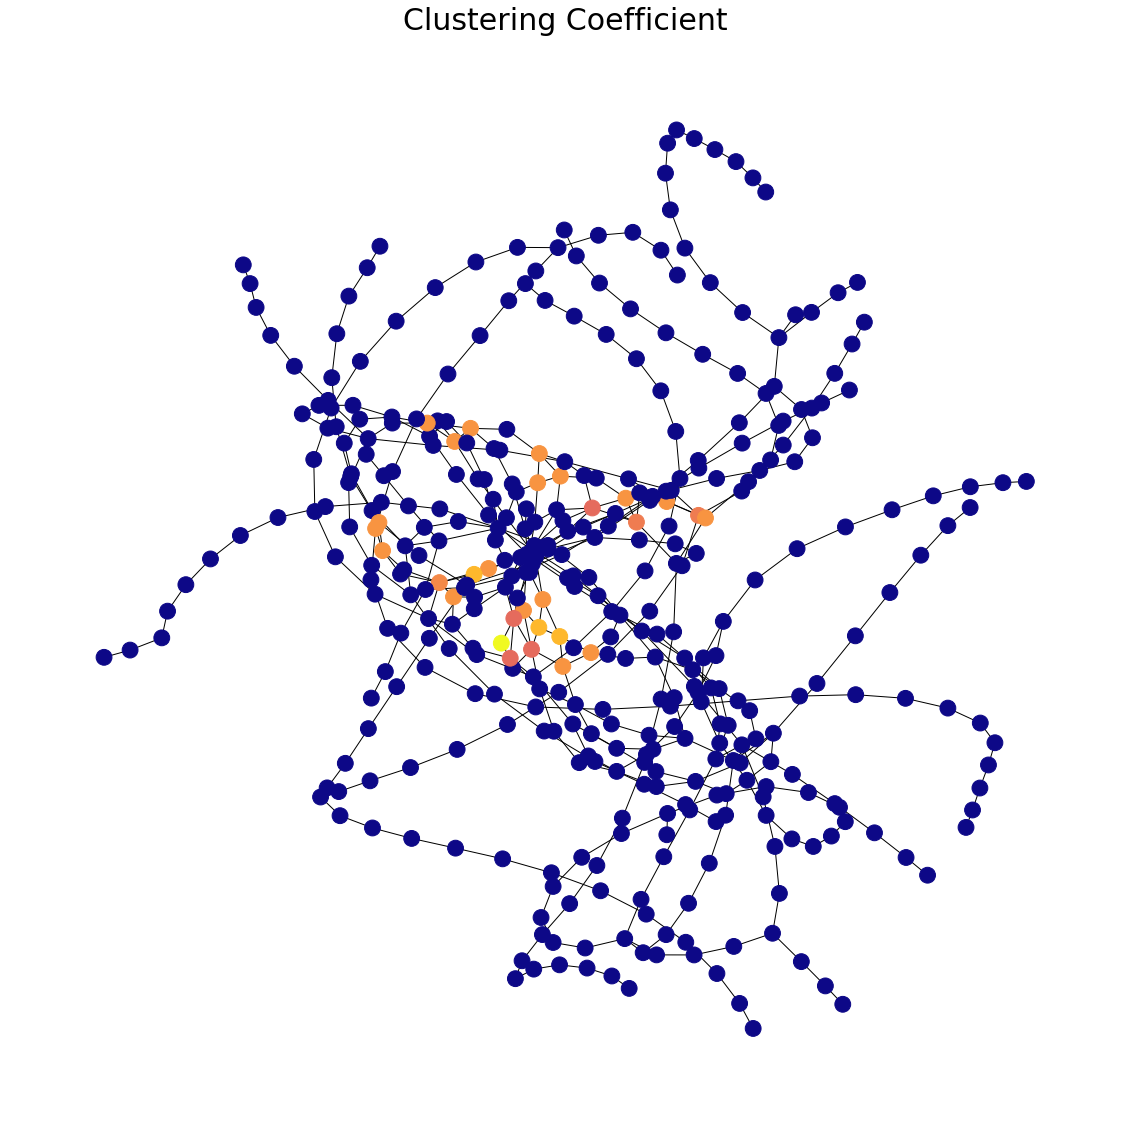

In [96]:
draw(G, pos, nx.clustering(G), 'Clustering Coefficient')